XGBoost Alg.

In [99]:
!pip install xgboost

In [100]:
pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [132]:
#imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

Importing Dataset

In [102]:
df = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Delimitate Data

In [103]:
y = df['stroke']
X  = df
X.drop('stroke', axis=1, inplace=True) 
X.drop('id', axis=1, inplace=True)

Split to train & test

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.33, random_state=67)

Create Pipeline

In [119]:
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
sample_weights = compute_sample_weight({0:0.08457286432160804, 1:0.915427135678392}, y_train)
sample_weights = np.array(sample_weights)

numeric_features = ['age', 'avg_glucose_level', 'bmi']
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type',
        'smoking_status']
categorical_transformer = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categories', categorical_transformer, categorical_features)],
    remainder='passthrough'
)

estimators = [
        ('preprocess', preprocessor),
        ('clf', XGBClassifier(random_state=67))
    ]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('categories',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_type',
                                                   'smoking_status'])])),
                ('clf'...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=67, ...))])

Hypertuning: BayesSearch

In [121]:
search_space={
    'clf__max_depth':Integer(2,8),
    'clf__learning_rate':Real(0.1, 0.5, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode': Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0),
}
optimize = BayesSearchCV(pipe, search_space, cv=5, n_iter=10, scoring='f1', random_state=67)

Train XGBoost Model

In [122]:
optimize.fit(X_train, y_train, clf__sample_weight=sample_weights)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocess',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('numeric',
                                                                          Pipeline(steps=[('scaler',
                                                                                           MinMaxScaler())]),
                                                                          ['age',
                                                                           'avg_glucose_level',
                                                                           'bmi']),
                                                                         ('categories',
                                                                          Pipeline(steps=[('ohe',
                                                                                           OneHotEncoder(drop='first',
                                                                                                         handle_unknown='ignore'))]),
                                                                          ['gender',
                                                                           'ever_married',
                                                                           'work_type',
                                                                           'Residence_type'...
                             'clf__learning_rate': Real(low=0.1, high=0.5, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

Evaluate Model

In [147]:
best_estimator =  optimize.best_estimator_
print("Best estimator:", best_estimator)

Best estimator: Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('categories',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                              

In [148]:
print("Best score:", optimize.best_score_)

Best score: 0.27783640435576556


In [149]:
optimize.score(X_test, y_test)

c:\Users\Rotaru Mira\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.25389221556886227

Make prediction

In [150]:
y_pred = optimize.predict(X_test)

c:\Users\Rotaru Mira\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [129]:
optimize.predict_proba(X_test)

c:\Users\Rotaru Mira\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([[0.43681574, 0.56318426],
       [0.6138277 , 0.38617232],
       [0.39930195, 0.60069805],
       ...,
       [0.89969695, 0.10030304],
       [0.6089393 , 0.39106068],
       [0.42604685, 0.57395315]], dtype=float32)

In [151]:
print("F1 Score:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

F1 Score: 0.25389221556886227
Accuracy: 0.8180490654205608
Precision: 0.15915915915915915
Recall: 0.6272189349112426


Measure feature importance

In [152]:
best_estimator = optimize.best_estimator_.steps

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

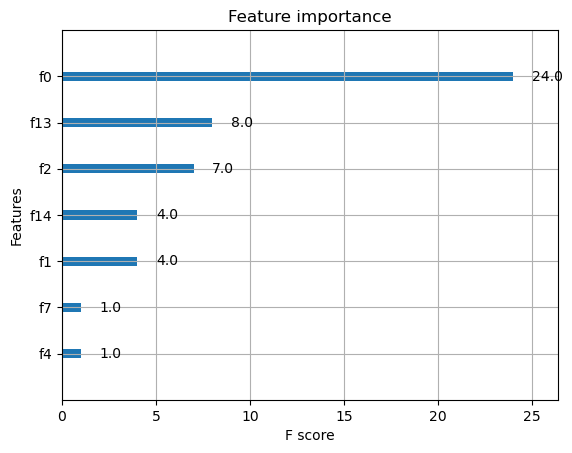

In [153]:
from xgboost import plot_importance

xgboost_step = optimize.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)

Print parameters

In [159]:
for step_name, step_obj in best_estimator:
    print(f"Step: {step_name}")
    print(step_obj.get_params()) 

Step: preprocess
{'n_jobs': None, 'remainder': 'passthrough', 'sparse_threshold': 0.3, 'transformer_weights': None, 'transformers': [('numeric', Pipeline(steps=[('scaler', MinMaxScaler())]), ['age', 'avg_glucose_level', 'bmi']), ('categories', Pipeline(steps=[('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))]), ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])], 'verbose': False, 'verbose_feature_names_out': True, 'numeric': Pipeline(steps=[('scaler', MinMaxScaler())]), 'categories': Pipeline(steps=[('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))]), 'numeric__memory': None, 'numeric__steps': [('scaler', MinMaxScaler())], 'numeric__verbose': False, 'numeric__scaler': MinMaxScaler(), 'numeric__scaler__clip': False, 'numeric__scaler__copy': True, 'numeric__scaler__feature_range': (0, 1), 'categories__memory': None, 'categories__steps': [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))], 'categories__verbose': False, 'catego